# Imports

In [139]:
# Third Party
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor

# Native
import os

# Load Data

In [ ]:
# PostgreSQL credentials and database details
load_dotenv() # take environment variables from .env.
db_user = os.getenv("POSTGRESQL_USERNAME")
db_password = os.getenv("POSTGRESQL_PWD")
db_host = 'localhost' # Or your PostgreSQL server IP/hostname
db_port = '5432'      # Default PostgreSQL port
db_name = 'tile_db'

In [ ]:
cluster_label = 'norm_cluster_label' # norm_cluster_label , cluster_label
table_name = 'miles_walked_by_cluster' if cluster_label == 'cluster_label' else 'miles_walked_by_norm_cluster'
query = f"""
SELECT 
	t.{cluster_label},
	t.tag,
	mn.miles_walked_in_cluster

FROM tags as t
INNER JOIN {table_name} as mn
ON t.{cluster_label} = mn.{cluster_label}
;
"""
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')
tagsdf = pd.read_sql(query, engine)
engine.dispose()
tagsdf

,norm_cluster_label,tag,miles_walked_in_cluster
0,-3,transit,79.950430
1,-1,outlier,233.318354
2,84,plus_code,0.175375
3,84,establishment,0.175375
4,84,point_of_interest,0.175375
...,...,...,...
14413,1681,point_of_interest,8.133302
14414,1681,store,8.133302
14415,1681,supermarket,8.133302
14416,1681,route,8.133302


# Data Exploration

<BarContainer object of 32 artists>

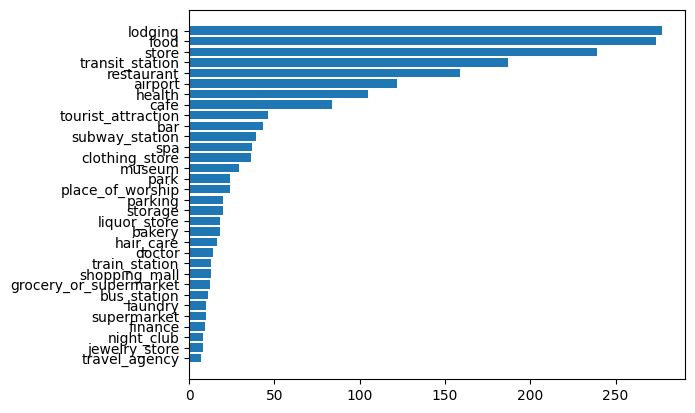

In [123]:
tag_counts = tagsdf['tag'].value_counts().sort_values(ascending=True).reset_index()
not_interesting_tags = list(tag_counts['tag'].tail(7).values) + ['political'] + [tag for tag in tag_counts['tag'].unique() if 'locality' in tag]
tag_counts = tag_counts[(tag_counts['count'] > 5) & (~tag_counts['tag'].isin(not_interesting_tags))]
fig, ax = plt.subplots()
ax.barh(y=tag_counts['tag'], width=tag_counts['count'].values)

# Data Prep

In [124]:
# remove boring tags and any that show up less than 5 times from above
mldf = tagsdf[tagsdf['tag'].isin(tag_counts['tag'])]
# from initial exploration, models perform awful on clusters with miles walked > 10 -- must be something weird happening
# realistically we only had ~3-4 days when we walked more than 10 miles
mldf = mldf[mldf['miles_walked_in_cluster'] < 10]
tags = list(tag_counts['tag'].values)
mldf.loc[:, tags] = pd.get_dummies(mldf['tag'], dtype=float)
mldf = mldf.groupby(cluster_label).max().reset_index()
mldf

,norm_cluster_label,tag,miles_walked_in_cluster,travel_agency,jewelry_store,night_club,finance,supermarket,laundry,bus_station,grocery_or_supermarket,shopping_mall,train_station,doctor,hair_care,bakery,liquor_store,storage,parking,place_of_worship,park,museum,clothing_store,spa,subway_station,bar,tourist_attraction,cafe,health,airport,restaurant,transit_station,store,food,lodging
0,2,transit_station,0.176681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,3,restaurant,0.589285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,5,restaurant,0.369790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,10,store,0.263219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,13,airport,1.027868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,2890,restaurant,2.629226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
328,2915,store,4.765598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
329,2924,store,2.770464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
330,2953,park,3.020872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
X = mldf[tags]
y = mldf['miles_walked_in_cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 69)
print(f"training: {X_train.shape[0]}\ntesting: {X_test.shape[0]}")

training: 265
testing: 67


In [138]:
X.corrwith(y).sort_values(ascending=False)

lodging                   0.309819
supermarket               0.152944
hair_care                 0.106253
grocery_or_supermarket    0.095234
restaurant                0.079261
spa                       0.076836
liquor_store              0.072762
laundry                   0.063683
park                      0.047926
store                     0.042370
food                      0.041939
health                    0.039970
storage                   0.026816
doctor                    0.022654
night_club                0.018167
clothing_store            0.004816
finance                  -0.004444
bar                      -0.010474
place_of_worship         -0.013053
shopping_mall            -0.013404
parking                  -0.015053
bakery                   -0.026521
museum                   -0.027922
jewelry_store            -0.035415
cafe                     -0.036196
subway_station           -0.036310
train_station            -0.039910
bus_station              -0.051041
travel_agency       

# Modelling

## Simple

In [136]:
def plot_results(y_pred, y_test, ax1, ax2, title):
    # fig, ax = plt.subplots(1,2,figsize=(8,4),layout='tight')
    ax1.scatter(y_pred,y_test);
    ax1.set_xlabel('Predicted');
    ax1.set_ylabel('True');
    ax1.set_title(title)
    ax2.hist(y_pred-y_test, bins=20);
    ax2.set_xlabel('Residual');
    ax2.set_ylabel('Count');

In [135]:
lr = LinearRegression()
scores = cross_validate(lr,X,y,cv=10)
print(np.mean(scores['test_score']))

lr = Lasso()
scores = cross_validate(lr,X,y,cv=10)
print(np.mean(scores['test_score']))

lr = Ridge()
scores = cross_validate(lr,X,y,cv=10)
print(np.mean(scores['test_score']))

-1.4301802659316807
-0.628313908334702
-1.0662219706118432


-0.2911545712439625
-0.0018186848916950105
-0.06492652112681019
-0.20449261281336262


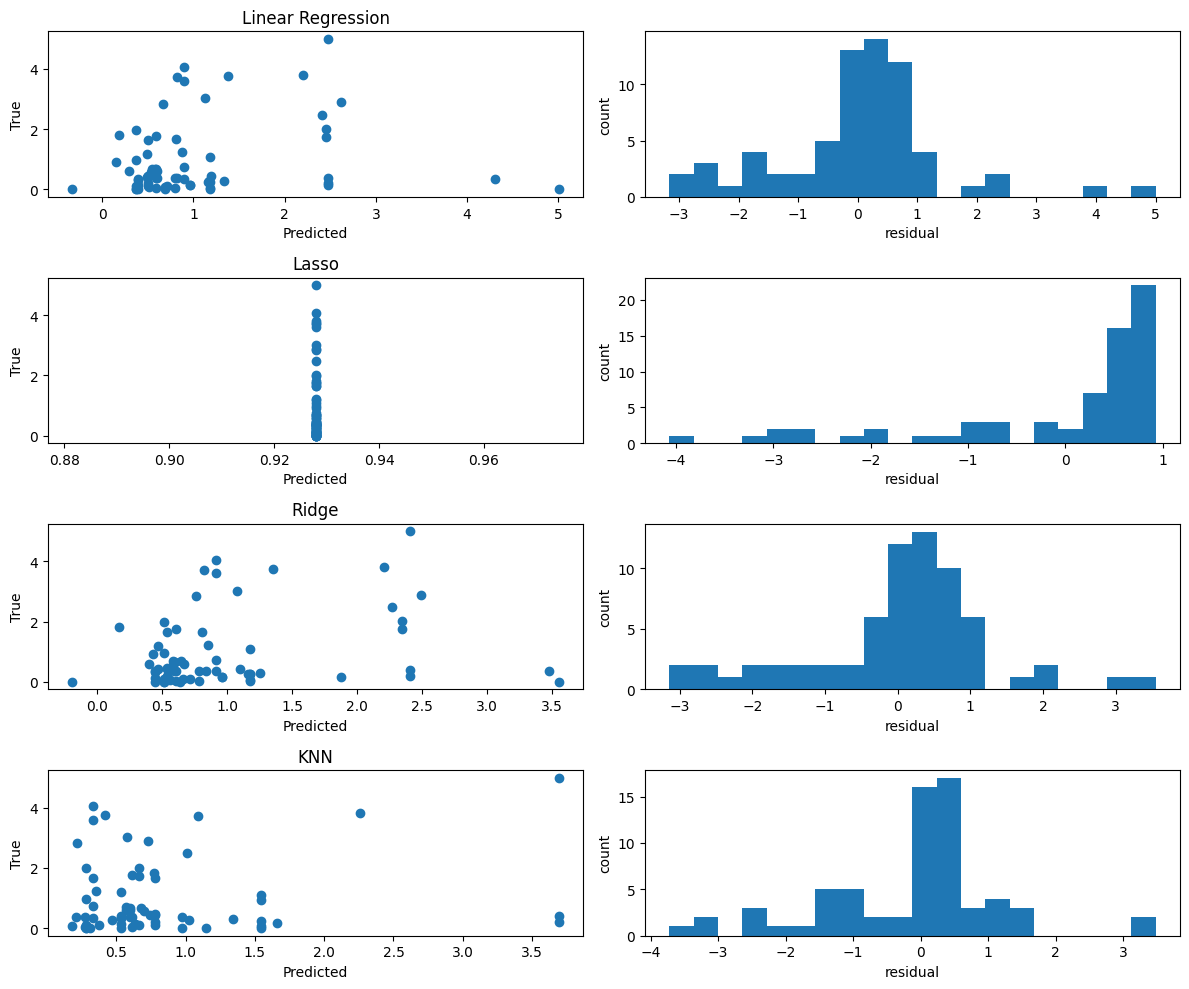

In [127]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(lr.score(X_test, y_test))

la = Lasso()
la.fit(X_train, y_train)
la_pred = la.predict(X_test)
print(la.score(X_test, y_test))

ri = Ridge()
ri.fit(X_train, y_train)
ri_pred = ri.predict(X_test)
print(ri.score(X_test, y_test))

knn = KNeighborsRegressor(n_neighbors = 5, n_jobs=-1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(knn.score(X_test, y_test))

fig, ax = plt.subplots(4,2, figsize=(12,10), layout='tight')
plot_results(lr_pred, y_test, ax[0,0], ax[0,1], 'Linear Regression')
plot_results(la_pred, y_test, ax[1,0], ax[1,1], 'Lasso')
plot_results(ri_pred, y_test, ax[2,0], ax[2,1], 'Ridge')
plot_results(knn_pred, y_test, ax[3,0], ax[3,1], 'KNN')

## Simple +

In [155]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
lr = LinearRegression()
lr_scores = cross_validate(lr,X_poly,y,cv=10, return_estimator=True)
print(np.mean(scores['test_score']))

lr = Lasso()
scores = cross_validate(lr,X_poly,y,cv=10)
print(np.mean(scores['test_score']))

lr = Ridge()
scores = cross_validate(lr,X_poly,y,cv=10)
print(np.mean(scores['test_score']))

-1.634040697151266
-0.628313908334702
-1.634040697151266


In [165]:
lr_best = lr_scores['estimator'][np.argmax(lr_scores['test_score'])]
f"{poly.get_feature_names_out()[np.argmax(lr_best.coef_)]} : {np.max(lr_best.coef_)}"
feature_names = poly.get_feature_names_out()
feature_values = lr_best.coef_
feats = {name:value for name, value in zip(feature_names, feature_values)}
feats = {k:v for k,v in sorted(feats.items(), key=lambda item: -item[1])}
feats

{'store lodging': np.float64(4.364967096901819),
 'place_of_worship clothing_store': np.float64(3.0763076166160896),
 'health restaurant': np.float64(2.7899064946871643),
 'liquor_store cafe': np.float64(2.5915032040541512),
 'storage cafe': np.float64(2.5915032040541512),
 'place_of_worship store': np.float64(2.4661691914937527),
 'park restaurant': np.float64(2.069380680912049),
 'spa restaurant': np.float64(1.913922136585073),
 'spa food': np.float64(1.913922136585073),
 'tourist_attraction transit_station': np.float64(1.6939291584213252),
 'park food': np.float64(1.6437905394831176),
 'train_station store': np.float64(1.6082847968565068),
 'health lodging': np.float64(1.47603144758715),
 'bar lodging': np.float64(1.3809431320680046),
 'museum tourist_attraction': np.float64(1.300513083822663),
 'hair_care': np.float64(1.1896164366784139),
 'hair_care^2': np.float64(1.1896164366784108),
 'place_of_worship cafe': np.float64(1.1495090595552402),
 'place_of_worship restaurant': np.floa

# Bottom